# Song Recommender
## Derek Hu & Maile Naito | COEN 140 | March 23, 2018

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Retrieve & Format Data

In [2]:
data = pd.DataFrame.from_csv('song_data.csv', sep=',', index_col=None)

audio_features = pd.DataFrame.from_csv('spotify.csv', sep=',', index_col=None)
audio_features = audio_features.drop(['id', 'analysis_url', 'duration_ms', 'track_href', 'type', 'uri', 'mode'], axis = 1)
audio_features = audio_features.dropna()

songs = pd.DataFrame(audio_features.loc[:,['song']].values, columns=['song']).set_index('song')

audio_features = audio_features.set_index('song')
std_audio_features = StandardScaler().fit_transform(audio_features)

## Set up K-NN

In [3]:
song_matrix = pd.pivot_table(data, index = 'song', columns = 'user_id', values = 'listen_count', fill_value = 0)

song_knn = NearestNeighbors(metric='cosine', algorithm='brute')
song_knn.fit(song_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

## Set up K-Means

### Elbow point check

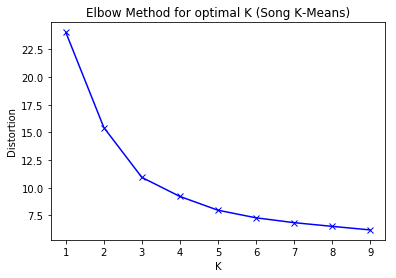

In [15]:
kmn_distortion = []
K = range(1,10)
for k in K:
    kmn_model = KMeans(n_clusters = k).fit(audio_features)
    kmn_distortion.append(sum(np.min(cdist(audio_features, kmn_model.cluster_centers_, 'euclidean'), axis=1)) / audio_features.shape[0])

plt.plot(K, kmn_distortion, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('Elbow Method for optimal K (Song K-Means)')
plt.show()

In [5]:
kmn_n_clusters = 3
kmn = KMeans(n_clusters = kmn_n_clusters).fit(audio_features)

kmn_clusters = []
for i in range(kmn_n_clusters):
    kmn_clusters.append(np.asarray([audio_features.index[j] for j in np.where(kmn.labels_ == i)[0]]))

## Set up PCA + K-Means

### Elbow point check

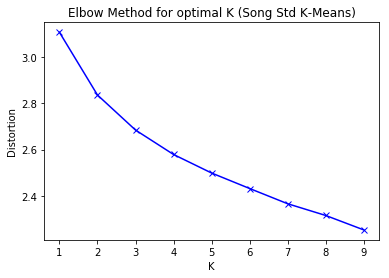

In [14]:
PCA_distortions = []
K = range(1,10)
for k in K:
    PCA_model = KMeans(n_clusters = k).fit(std_audio_features)
    PCA_distortions.append(sum(np.min(cdist(std_audio_features, PCA_model.cluster_centers_, 'euclidean'), axis=1)) / std_audio_features.shape[0])

plt.plot(K, PCA_distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('Elbow Method for optimal K (Song Std K-Means)')
plt.show()

In [7]:
pca = PCA(n_components=7)
PC = pca.fit_transform(std_audio_features)

PC = pd.DataFrame(data = PC, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7']).reset_index(drop=True)
PC['song'] = songs.index
PCA_audio_features = PC.set_index('song')

PCA_n_clusters = 6
PCA_kmn = KMeans(n_clusters = PCA_n_clusters)
PCA_kmn.fit(PCA_audio_features)

PCA_clusters = []
for i in range(PCA_n_clusters):
    PCA_clusters.append(np.asarray([PCA_audio_features.index[j] for j in np.where(PCA_kmn.labels_ == i)[0]]))

### Check principal component variances & total variance

In [18]:
print("Principal compoenent variances:\n", pca.explained_variance_ratio_)
print("Total prinicpal component variance:", sum(pca.explained_variance_ratio_))

Principal compoenent variances:
 [ 0.24696592  0.13961263  0.10075713  0.09549748  0.08917661  0.08367134
  0.07762363]
Total prinicpal component variance: 0.833304748581


## Recommenders

### Get base song

In [10]:
song = input()

for i in range(kmn_n_clusters):
    if song in kmn_clusters[i]:
        kmn_index = [i, np.where(kmn_clusters[i]==song)[0][0]]
        break

print("K-Means - Song found in cluster", kmn_index)

for i in range(PCA_n_clusters):
    if song in PCA_clusters[i]:
        PCA_index = [i, np.where(PCA_clusters[i]==song)[0][0]]
        break

print("PCA + K-Means - Song found in cluster", PCA_index)

Through The Wire - Kanye West
K-Means - Song found in cluster [2, 2349]
PCA + K-Means - Song found in cluster [5, 558]


### Get matrices, distances, & indices

In [11]:
# K-NN
query = song_matrix.index.get_loc(song)
distances, indices = song_knn.kneighbors(song_matrix.iloc[query, :].values.reshape(1, -1), n_neighbors = 6)

# K-Means + K-NN
kmn_selection = pd.DataFrame(index=kmn_clusters[kmn_index[0]], data={'in': 0})
kmn_selection = data.join(kmn_selection, on='song').dropna()

kmn_cluster_matrix = pd.pivot_table(kmn_selection, index = 'song', columns = 'user_id', values = 'listen_count', fill_value = 0)
kmn_cluster_knn = NearestNeighbors(metric='cosine', algorithm='brute').fit(kmn_cluster_matrix)

kmn_query = kmn_cluster_matrix.index.get_loc(song)
kmn_distances, kmn_indices = kmn_cluster_knn.kneighbors(kmn_cluster_matrix.iloc[kmn_query, :].values.reshape(1, -1), n_neighbors = 6)

# PCA + K-Means + K-NN
PCA_selection = pd.DataFrame(index=PCA_clusters[PCA_index[0]], data={'in': 0})
PCA_selection = data.join(PCA_selection, on='song').dropna()

PCA_cluster_matrix = pd.pivot_table(PCA_selection, index = 'song', columns = 'user_id', values = 'listen_count', fill_value = 0)

PCA_cluster_knn = NearestNeighbors(metric='cosine', algorithm='brute').fit(PCA_cluster_matrix)

PCA_query = PCA_cluster_matrix.index.get_loc(song)
PCA_distances, PCA_indices = PCA_cluster_knn.kneighbors(PCA_cluster_matrix.iloc[PCA_query, :].values.reshape(1, -1), n_neighbors = 6)

### Give recommendations

In [12]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('K-NN Recommendations for {0}:\n'.format(song_matrix.index[query]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, song_matrix.index[indices.flatten()[i]], distances.flatten()[i]))

print('\n')

for i in range(0, len(kmn_distances.flatten())):
    if i == 0:
        print('K-NN with K-Means Recommendations for {0}:\n'.format(kmn_cluster_matrix.index[kmn_query]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, kmn_cluster_matrix.index[kmn_indices.flatten()[i]], kmn_distances.flatten()[i]))

print('\n')

for i in range(0, len(PCA_distances.flatten())):
    if i == 0:
        print('K-NN with K-Means & PCA Recommendations for {0}:\n'.format(PCA_cluster_matrix.index[PCA_query]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, PCA_cluster_matrix.index[PCA_indices.flatten()[i]], PCA_distances.flatten()[i]))

K-NN Recommendations for Through The Wire - Kanye West:

1: The Glory - Kanye West, with distance of 0.754036817514376:
2: Soon As I Get Home(Album Version) - Faith Evans, with distance of 0.786573180534062:
3: All Falls Down - Kanye West / Syleena Johnson, with distance of 0.7911657225974367:
4: Hey Mama - Kanye West, with distance of 0.8073298536450759:
5: It\'s Just A Thought - Creedence Clearwater Revival, with distance of 0.8229429490776607:


K-NN with K-Means Recommendations for Through The Wire - Kanye West:

1: The Glory - Kanye West, with distance of 0.754036817514376:
2: All Falls Down - Kanye West / Syleena Johnson, with distance of 0.7911657225974367:
3: Hey Mama - Kanye West, with distance of 0.8073298536450759:
4: Roses - Kanye West, with distance of 0.8308373545901873:
5: Family Business - Kanye West, with distance of 0.8681082343198461:


K-NN with K-Means & PCA Recommendations for Through The Wire - Kanye West:

1: The Glory - Kanye West, with distance of 0.7540368175